### Computing coherences 

Here we will use a toy model to test our functions to compute coherence

In [1]:
%matplotlib inline

import numpy                 as np
import matplotlib.pyplot     as plt
from   GDa.spectral_analysis import spectral

In [2]:
# Model we will use from Dhamala et. al., (2008)
def ar_model_dhamala(N=5000, Trials = 10, Fs = 200, C=0.2, t_start=0, t_stop=None, cov = None):
    T = N / Fs
    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N])
    Y = np.random.random([Trials, N])

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in range(Trials):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N):
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] +E[t,1]

    Z = np.zeros([2, Trials, N])

    Z[0] = X
    Z[1] = Y

    return Z

#### Single trial

In this example X is coupled to Y (Y$\rightarrow$X), but the coupling is turned of at t = 2.25 s. We will compute the transforms and the coherence for only one trial first.

In [3]:
# Generating signals
N  = 900      # Number of observations
Fs = 200      # Sampling frequency
dt = 1.0 / Fs # Time resolution
C  = 0.25     # Coupling parameter
Trials = 100  # Number of trials

freqs = np.arange(0.1,100,.1)

cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])
Z = ar_model_dhamala(N=N, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=2.25, cov=cov)
Z = np.swapaxes(Z, 0, 1)
X = np.squeeze(Z[0,0,:])
Y = np.squeeze(Z[0,1,:])

In [4]:
# Instantiating spectral class
spec = spectral()

In [5]:
# Computing wavelet spectra
#1. Morlet
Sxx_morlet, Syy_morlet, Sxy_morlet = spec.wavelet_spectrum(signal1 = X[np.newaxis,np.newaxis,:], signal2 = Y[np.newaxis,np.newaxis,:], 
                        fs = Fs, freqs = freqs, n_cycles = freqs/2.0, 
                        smooth_window = 500, time_bandwidth = None, 
                        method = 'morlet', n_jobs = -1) 
#2. Multitaper
Sxx_multitaper, Syy_multitaper, Sxy_multitaper = spec.wavelet_spectrum(signal1 = X[np.newaxis,np.newaxis,:], signal2 = Y[np.newaxis,np.newaxis,:], 
                        fs = Fs, freqs = freqs, n_cycles = freqs/2.0, 
                        smooth_window = 500, time_bandwidth = 8.0, 
                        method = 'multitaper', n_jobs = -1) 

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.2s finished


In [7]:
'''
width = 500
import scipy
# Computing spectra
Wx_morlet     = np.squeeze(Wx_morlet)
Wx_multitaper = np.squeeze(Wx_multitaper) 
Wy_morlet     = np.squeeze(Wy_morlet)
Wy_multitaper = np.squeeze(Wy_multitaper)
Wxy_morlet    = Wx_morlet * np.conj(Wy_morlet)
Wxy_multitaper= Wx_multitaper * np.conj(Wy_multitaper) 

kernel = np.ones([width, 1])

Sxx_morlet     = Wx_morlet*np.conj(Wx_morlet)#np.squeeze( np.multiply(Wx_morlet, np.conj(Wx_morlet)) ).real
Sxx_morlet     = scipy.signal.convolve2d(Sxx_morlet.T, kernel, mode='same').T
Sxx_multitaper = Wx_multitaper*np.conj(Wx_multitaper)#np.squeeze( np.multiply(Wx_multitaper, np.conj(Wx_multitaper)) ).real
Sxx_multitaper = scipy.signal.convolve2d(Sxx_multitaper.T, kernel, mode='same').T

Syy_morlet     = Wy_morlet*np.conj(Wy_morlet)#np.squeeze( np.multiply(Wy_morlet, np.conj(Wy_morlet)) ).real
Syy_morlet     = scipy.signal.convolve2d(Syy_morlet.T, kernel, mode='same').T
Syy_multitaper = Wy_multitaper*np.conj(Wy_multitaper)#np.squeeze( np.multiply(Wy_multitaper, np.conj(Wy_multitaper)) ).real
Syy_multitaper = scipy.signal.convolve2d(Syy_multitaper.T, kernel, mode='same').T

Sxy_morlet     = Wx_morlet*np.conj(Wy_morlet)
Sxy_morlet     = scipy.signal.convolve2d(Sxy_morlet.T, kernel, mode='same').T
Sxy_multitaper = Wx_multitaper*np.conj(Wy_multitaper)
Sxy_multitaper = scipy.signal.convolve2d(Sxy_multitaper.T, kernel, mode='same').T
'''

"\nwidth = 500\nimport scipy\n# Computing spectra\nWx_morlet     = np.squeeze(Wx_morlet)\nWx_multitaper = np.squeeze(Wx_multitaper) \nWy_morlet     = np.squeeze(Wy_morlet)\nWy_multitaper = np.squeeze(Wy_multitaper)\nWxy_morlet    = Wx_morlet * np.conj(Wy_morlet)\nWxy_multitaper= Wx_multitaper * np.conj(Wy_multitaper) \n\nkernel = np.ones([width, 1])\n\nSxx_morlet     = Wx_morlet*np.conj(Wx_morlet)#np.squeeze( np.multiply(Wx_morlet, np.conj(Wx_morlet)) ).real\nSxx_morlet     = scipy.signal.convolve2d(Sxx_morlet.T, kernel, mode='same').T\nSxx_multitaper = Wx_multitaper*np.conj(Wx_multitaper)#np.squeeze( np.multiply(Wx_multitaper, np.conj(Wx_multitaper)) ).real\nSxx_multitaper = scipy.signal.convolve2d(Sxx_multitaper.T, kernel, mode='same').T\n\nSyy_morlet     = Wy_morlet*np.conj(Wy_morlet)#np.squeeze( np.multiply(Wy_morlet, np.conj(Wy_morlet)) ).real\nSyy_morlet     = scipy.signal.convolve2d(Syy_morlet.T, kernel, mode='same').T\nSyy_multitaper = Wy_multitaper*np.conj(Wy_multitaper)#np.sq

Text(0.5, 0, 'Time [s]')

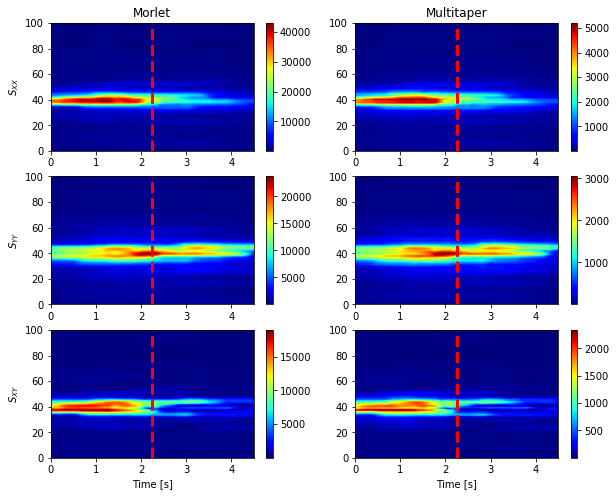

In [8]:
plt.figure(figsize = (10,8))
plt.subplot(3,2,1)
plt.imshow(Sxx_morlet.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.title('Morlet')
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.ylabel('$S_{XX}$')
plt.subplot(3,2,2)
plt.imshow(Sxx_multitaper.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.title('Multitaper')
plt.subplot(3,2,3)
plt.imshow(Syy_morlet.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.ylabel('$S_{YY}$')
plt.subplot(3,2,4)
plt.imshow(Syy_multitaper.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.subplot(3,2,5)
plt.imshow(np.abs(Sxy_morlet), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.xlabel('Time [s]')
plt.ylabel('$S_{XY}$')
plt.subplot(3,2,6)
plt.imshow(np.abs(Sxy_multitaper), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.xlabel('Time [s]')

Now let's compute the coherence

In [12]:
# Computing coherence
C_morlet     = spec.coherence(signal1 = X[np.newaxis,np.newaxis,:], signal2 = Y[np.newaxis,np.newaxis,:], 
                     fs = Fs, freqs = freqs, n_cycles = freqs/2.0, smooth_window = 500,
                     time_bandwidth = 8.0, method = 'morlet', n_jobs = -1)

C_multitaper = spec.coherence(signal1 = X[np.newaxis,np.newaxis,:], signal2 = Y[np.newaxis,np.newaxis,:], 
                     fs = Fs, freqs = freqs, n_cycles = freqs/2.0, smooth_window = 500,
                     time_bandwidth = 8.0, method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.3s finished


Text(0.5, 0, 'Time [s]')

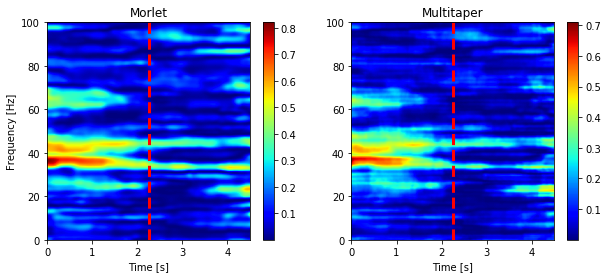

In [13]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(C_morlet.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100])
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3); plt.colorbar()
plt.title('Morlet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(C_multitaper.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100])
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3); plt.colorbar()
plt.title('Multitaper')
plt.xlabel('Time [s]')